In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
from mistune.plugins.math import math
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_base_path = r'E:\PycharmProjects\pythonProject1\iiot2024'


In [3]:
types = {
    'ts': 'float64',  # Timestamp, likely in float format
    'flow_duration': 'float32',  # Same as original
    'Header_Length': 'int64',  # Same as original 'header_length'
    'Source IP': 'object',  # IP addresses as strings
    'Destination IP': 'object',  # IP addresses as strings
    'Source Port': 'int32',  # Ports can be stored as integers
    'Destination Port': 'int32',  # Same as source port
    'Protocol Type': 'int8',  # Assuming small integer range for protocol types
    'Protocol_name': 'object',  # Protocol names as strings
    'Duration': 'float32',  # Same as original 'duration'
    'Rate': 'float32',  # Replacing 'rate'
    'Srate': 'float32',  # Same as original 'srate'
    'Drate': 'float32',  # Same as original 'drate'
    'fin_flag_number': 'uint8',  # Same as original
    'syn_flag_number': 'uint8',  # Same as original
    'rst_flag_number': 'uint8',  # Same as original
    'psh_flag_number': 'uint8',  # Same as original
    'ack_flag_number': 'uint8',  # Same as original
    'urg_flag_number': 'uint8',  # New, inferred from context
    'ece_flag_number': 'uint8',  # Same as original
    'cwr_flag_number': 'uint8',  # Same as original
    'ack_count': 'float32',  # Same as original
    'syn_count': 'float32',  # Same as original
    'fin_count': 'float32',  # Same as original
    'urg_count': 'float32',  # Same as original
    'rst_count': 'float32',  # Same as original
    'max_duration': 'float32',  # New field inferred from context
    'min_duration': 'float32',  # New field inferred from context
    'sum_duration': 'float32',  # New field inferred from context
    'average_duration': 'float32',  # New field inferred from context
    'std_duration': 'float32',  # New field inferred from context
    'CoAP': 'uint8',  # New field, protocol flag
    'HTTP': 'uint8',  # Protocol flag
    'HTTPS': 'uint8',  # Protocol flag
    'DNS': 'uint8',  # Protocol flag
    'Telnet': 'uint8',  # Protocol flag
    'SMTP': 'uint8',  # Protocol flag
    'SSH': 'uint8',  # Protocol flag
    'IRC': 'uint8',  # Protocol flag
    'TCP': 'uint8',  # Protocol flag
    'UDP': 'uint8',  # Protocol flag
    'DHCP': 'uint8',  # Protocol flag
    'ARP': 'uint8',  # Protocol flag
    'ICMP': 'uint8',  # Protocol flag
    'IGMP': 'uint8',  # Protocol flag
    'IPv': 'uint8',  # Protocol flag
    'LLC': 'uint8',  # Protocol flag
    'Tot sum': 'float32',  # Replacing 'tot_sum'
    'Min': 'float32',  # Replacing 'min'
    'Max': 'float32',  # Replacing 'max'
    'AVG': 'float32',  # Replacing 'avg'
    'Std': 'float32',  # Replacing 'std'
    'Tot size': 'float32',  # Replacing 'tot_size'
    'IAT': 'float32',  # Replacing 'iat'
    'Number': 'float32',  # Replacing 'number'
    'MAC': 'object',  # Likely MAC address, stored as a string
    'Magnitue': 'float32',  # Inferred from context
    'Radius': 'float32',  # Same as original 'radius'
    'Covariance': 'float32',  # Same as original 'covariance'
    'Variance': 'float32',  # Same as original 'variance'
    'Weight': 'float32',  # Same as original 'weight'
    'DS status': 'uint8',  # New field, inferred from context
    'Fragments': 'uint8',  # New field, inferred from context
    'Sequence number': 'int64',  # New field, inferred from context
    'Protocol Version': 'int8',  # New field, inferred from context
    'flow_idle_time': 'float32',  # New field, inferred from context
    'flow_active_time': 'float32',  # New field, inferred from context
    'label': 'object',  # Same as original
    'subLabel': 'object',  # New field, inferred from context
    'subLabelCat': 'object'  # New field, inferred from context
}

def replace_infinity_with_mean(df):
    modified_rows = 0
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        modified_rows += df[df[col] == np.inf].shape[0]
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df, modified_rows

def replace_negative_values_with_mean(df):
    modified_rows = 0
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        modified_rows += df[df[col] < 0].shape[0]
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df, modified_rows

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))

    df, infinity_modified_rows = replace_infinity_with_mean(df)
    df, negative_modified_rows = replace_negative_values_with_mean(df)

    total_modified_rows = infinity_modified_rows + negative_modified_rows
    print(f'عدد السطور المعدلة للقيم اللانهائية: {infinity_modified_rows}')
    print(f'عدد السطور المعدلة للقيم السالبة: {negative_modified_rows}')
    print(f'إجمالي عدد السطور المعدلة: {total_modified_rows}')

    return df

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
df

عدد السطور المعدلة للقيم اللانهائية: 0
عدد السطور المعدلة للقيم السالبة: 0
إجمالي عدد السطور المعدلة: 0


,ts,flow_duration,Header_Length,Source IP,Destination IP,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,...,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,label,subLabel,subLabelCat
0,1.701426e+09,0.000000,66,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,1.0,0,0,0,0,1.701426e+09,0.000000,0,0,0
1,1.701426e+09,0.002112,132,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,4.0,0,0,0,0,2.112150e-03,0.002112,0,0,0
2,1.701426e+09,0.002328,198,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,9.0,0,0,0,0,2.160072e-04,0.002328,0,0,0
3,1.701426e+09,0.004329,264,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,16.0,0,0,0,0,2.001047e-03,0.004329,0,0,0
4,1.701426e+09,0.009495,330,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,25.0,0,0,0,0,5.165815e-03,0.009495,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,100.0,0,0,0,0,2.312660e-05,2.018212,0,0,0
9536819,1.701550e+09,0.021296,1432,172.16.66.128,172.16.64.128,502,55784,6,TCP,64.0,...,121.0,0,0,0,0,2.112150e-03,0.021296,0,0,0
9536820,1.701550e+09,2.018227,5670,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,144.0,0,0,0,0,1.478195e-05,2.018227,0,0,0
9536821,1.701550e+09,2.018277,5880,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,169.0,0,0,0,0,5.006790e-05,2.018277,0,0,0


In [5]:
import socket
import struct
import pandas as pd

def ip_to_int(ip_address):
    try:
        return struct.unpack("!I", socket.inet_aton(ip_address))[0]
    except socket.error:
        return None



df['Source IP (int)'] = df['Source IP'].apply(ip_to_int)
df['Destination IP (int)'] = df['Destination IP'].apply(ip_to_int)

# عرض النتائج
print(df)


                   ts  flow_duration  Header_Length      Source IP  \
0        1.701426e+09       0.000000             66  172.16.64.128   
1        1.701426e+09       0.002112            132  172.16.64.128   
2        1.701426e+09       0.002328            198  172.16.64.128   
3        1.701426e+09       0.004329            264  172.16.64.128   
4        1.701426e+09       0.009495            330  172.16.64.128   
...               ...            ...            ...            ...   
9536818  1.701550e+09       2.018212           5460  172.16.66.128   
9536819  1.701550e+09       0.021296           1432  172.16.66.128   
9536820  1.701550e+09       2.018227           5670  172.16.66.128   
9536821  1.701550e+09       2.018277           5880  172.16.66.128   
9536822  1.701550e+09       2.018348           6090  172.16.66.128   

          Destination IP  Source Port  Destination Port  Protocol Type  \
0          172.16.66.128        41750               502              6   
1          

In [6]:
X = df.drop(columns=['label','subLabel','subLabelCat','Source IP','Destination IP','Protocol_name'])
y = df[['label']]

In [7]:
X

,ts,flow_duration,Header_Length,Source Port,Destination Port,Protocol Type,Duration,Rate,Srate,Drate,...,Variance,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,Source IP (int),Destination IP (int)
0,1.701426e+09,0.000000,66,41750,502,6,64.0,0.000000,0.000000,0.0,...,0.0,1.0,0,0,0,0,1.701426e+09,0.000000,2886746240,2886746752
1,1.701426e+09,0.002112,132,41750,502,6,64.0,946.902344,946.902344,0.0,...,0.0,4.0,0,0,0,0,2.112150e-03,0.002112,2886746240,2886746752
2,1.701426e+09,0.002328,198,41750,502,6,64.0,1288.572632,1288.572632,0.0,...,0.0,9.0,0,0,0,0,2.160072e-04,0.002328,2886746240,2886746752
3,1.701426e+09,0.004329,264,41750,502,6,64.0,923.957275,923.957275,0.0,...,0.0,16.0,0,0,0,0,2.001047e-03,0.004329,2886746240,2886746752
4,1.701426e+09,0.009495,330,41750,502,6,64.0,526.591858,526.591858,0.0,...,0.0,25.0,0,0,0,0,5.165815e-03,0.009495,2886746240,2886746752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,41544,1900,17,1.0,12.882689,12.882689,0.0,...,1.0,100.0,0,0,0,0,2.312660e-05,2.018212,2886746752,4026531834
9536819,1.701550e+09,0.021296,1432,502,55784,6,64.0,939.142456,939.142456,0.0,...,1.0,121.0,0,0,0,0,2.112150e-03,0.021296,2886746752,2886746240
9536820,1.701550e+09,2.018227,5670,41544,1900,17,1.0,13.378079,13.378079,0.0,...,1.0,144.0,0,0,0,0,1.478195e-05,2.018227,2886746752,4026531834
9536821,1.701550e+09,2.018277,5880,41544,1900,17,1.0,13.873220,13.873220,0.0,...,1.0,169.0,0,0,0,0,5.006790e-05,2.018277,2886746752,4026531834


In [8]:
y.label.value_counts()

label
0    21598215
1        1004
Name: count, dtype: int64

In [10]:
selected_features = [
    'ts', 'flow_duration', 'Source Port', 'Destination Port', 'Protocol Type', 'Duration', 'Rate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'ARP', 'ICMP', 'IGMP', 'IPv',
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance', 'Source IP (int)', 'Destination IP (int)'
]
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 33


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(units=128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    GRU(units=64, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),

    Dense(units=128, activation='relu'),
    Dropout(0.3),

    Dense(units=num_classes, activation='softmax')  # تصنيف متعدد
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Epoch 1/100
13500/13500 [==============================] - 219s 16ms/step - loss: 6.1201e-04 - accuracy: 0.9999 - val_loss: 1.9391e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/100
13500/13500 [==============================] - 232s 17ms/step - loss: 2.0065e-04 - accuracy: 1.0000 - val_loss: 1.8370e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
13500/13500 [==============================] - 241s 18ms/step - loss: 1.9097e-04 - accuracy: 1.0000 - val_loss: 1.7830e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/100
13500/13500 [==============================] - 250s 19ms/step - loss: 1.6308e-04 - accuracy: 1.0000 - val_loss: 1.5708e-04 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/100
13500/13500 [==============================] - 253s 19ms/step - loss: 1.5297e-04 - accuracy: 1.0000 - val_loss: 1.6465e-04 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 6/100
13500/13500 [==============================] - 255s 19ms/step - loss: 1.4357e-04 - accuracy: 1.0000 - val_loss: 1.4863e-04 - 

In [13]:
# 6. تقييم النموذج
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# 7. طباعة تقرير التصنيف
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)



# 8. رسم منحنى التدريب


Loss: 0.0001
Accuracy: 1.0000
134996/134996 [==============================] - 108s 793us/step


In [15]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # تحويل الاحتمالات إلى فئات متوقعة

# **تعديل هنا: تحويل y_test إلى int**
y_test = y_test.astype(int)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

134996/134996 [==============================] - 163s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4319643
           1       0.80      0.60      0.68       201

    accuracy                           1.00   4319844
   macro avg       0.90      0.80      0.84   4319844
weighted avg       1.00      1.00      1.00   4319844



In [2]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test = y_test.astype(int)


NameError: name 'model' is not defined

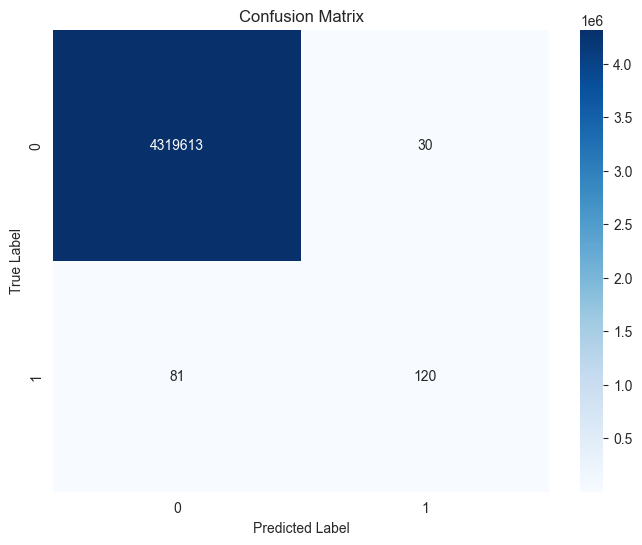

In [16]:
from sklearn.metrics import classification_report, confusion_matrix


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def calculate_latency(model, X_test, iterations=10):
    """
     Average Prediction Latency Per Sample.


      Args:
        model: Trained model with .predict method.
        X_test: Test data.
        iterations: Number of iterations to average latency over.
      Returns:
        average_latency_per_row: The average latency per row across all iterations
    """
    total_latency = 0
    num_rows = X_test.shape[0]

    for _ in range(iterations):
        start_time = time.time()

        # Data Preparation (Dummy Preprocessing as example, replace with your processing pipeline)
        X_test_prep = X_test.copy()  # This represents your preprocessing, you can scale as you did in your code if you want.

        # Prediction step
        model.predict(X_test_prep)

        end_time = time.time()
        total_latency += (end_time - start_time)

    average_latency = total_latency / iterations
    average_latency_per_row = average_latency / num_rows
    return average_latency_per_row


average_latency_cat = calculate_latency(model, X_test)
average_latency_cat

134996/134996 [==============================] - 173s 1ms/step


5.555274332533237e-05

In [18]:
import psutil
import os
import time


def measure_prediction_memory_cost(model, X_test):
    """
    Memory Usage During Prediction on Test Set (MB)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
    Returns:
      memory_usage_mb: The increase in memory usage during the prediction, in MB.
    """

    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # in MB

    start_memory = get_memory_usage()
    model.predict(X_test)
    end_memory = get_memory_usage()

    memory_usage_mb = end_memory - start_memory
    return memory_usage_mb



memory_cost = measure_prediction_memory_cost(model, X_test)
print(f"Memory usage during prediction: {memory_cost:.2f} MB")

134996/134996 [==============================] - 163s 1ms/step
Memory usage during prediction: 93.13 MB


In [19]:
import psutil
import os
import time

def measure_prediction_cpu_cost(model, X_test, duration=3):
    """
    Average CPU Usage During Prediction on Test Set (%)
    System CPU time during prediction on  Test Set (seconds)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      duration : time in seconds to average cpu metrics over.
    Returns:
        cpu_percent: Average CPU usage percentage during prediction.
        user_cpu_time: User CPU time in seconds during the prediction.
        system_cpu_time: System CPU time in seconds during the prediction.
    """

    def get_cpu_usage():
      cpu_percent = psutil.cpu_percent()
      cpu_times = psutil.cpu_times()
      return cpu_percent, cpu_times.user, cpu_times.system

    cpu_usage_list = []
    user_cpu_time_list = []
    system_cpu_time_list = []

    start_time = time.time()
    while time.time() - start_time <= duration:
      cpu_percent, user_time, system_time = get_cpu_usage()
      cpu_usage_list.append(cpu_percent)
      user_cpu_time_list.append(user_time)
      system_cpu_time_list.append(system_time)
      time.sleep(0.1) # Check cpu every 0.1 second

    start_cpu_percent, start_user_time, start_system_time = get_cpu_usage()

    start_prediction_time = time.time()
    model.predict(X_test)
    end_prediction_time = time.time()

    cpu_percent, end_user_time, end_system_time = get_cpu_usage()

    total_user_time = end_user_time - start_user_time
    total_system_time = end_system_time - start_system_time

    return np.mean(cpu_usage_list), total_user_time, total_system_time




In [21]:
cpu_percent, user_cpu_time, system_cpu_time = measure_prediction_cpu_cost(model, X_test)
print(f"Average CPU usage during prediction: {cpu_percent:.2f}%")
print(f"User CPU time during prediction: {user_cpu_time:.2f} seconds")
print(f"System CPU time during prediction: {system_cpu_time:.2f} seconds")

134996/134996 [==============================] - 164s 1ms/step
Average CPU usage during prediction: 7.00%
User CPU time during prediction: 99.52 seconds
System CPU time during prediction: 58.36 seconds


In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import psutil
import os

def measure_prediction_scalability(model, X, y, test_size = 0.2, sizes = np.linspace(0.1, 1, 10), iterations = 3):
    """
    Measures scalability

    Args:
      model: Trained model with .predict method.
      X: Full Input dataframe.
      y: Full labels of the dataframe.
      test_size: size of the test set.
      sizes: Fractions of test data to evaluate over.
      iterations: Number of iterations to average over.
    Returns:
      sizes: Fraction of test data used in each run
      prediction_times: time taken to do predictions with each fraction of test data
    """
    prediction_times = []
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_size, random_state=42)

    for size in sizes:
        subset_size = int(len(X_test1) * size)
        X_test_subset = X_test1[:subset_size]


        total_prediction_time = 0
        for _ in range(iterations):
             start_time = time.time()
             model.predict(X_test_subset)
             end_time = time.time()
             total_prediction_time += (end_time-start_time)
        prediction_time = total_prediction_time/iterations


        prediction_times.append(prediction_time)

    return sizes, prediction_times



27000/27000 [==============================] - 38s 1ms/step


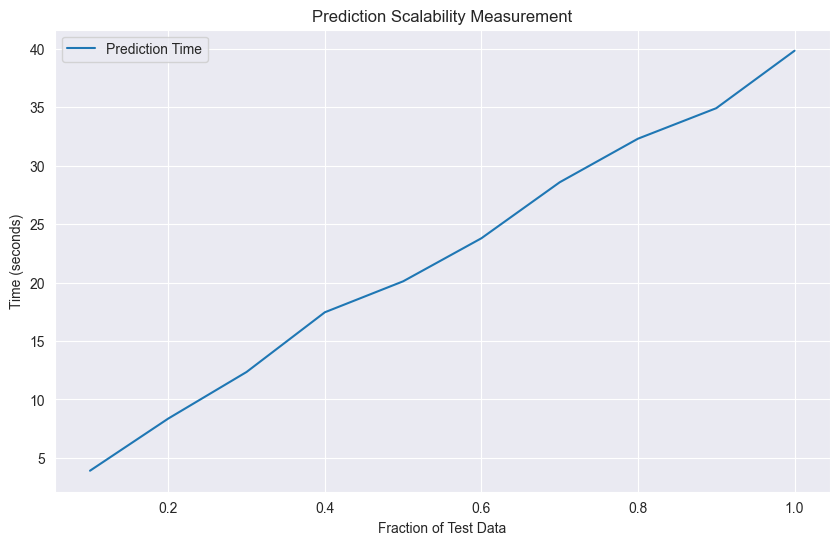

In [30]:
sizes, prediction_times = measure_prediction_scalability(model, X_test, y_test)
#
plt.figure(figsize=(10, 6))
plt.plot(sizes, prediction_times, label='Prediction Time')
plt.xlabel('Fraction of Test Data')
plt.ylabel('Time (seconds)')
plt.title('Prediction Scalability Measurement')
plt.legend()
plt.grid(True)
plt.show()